In [1]:
!pip install transformers

In [2]:
!pip install datasets

In [7]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-07-31 23:03:31.576493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:03:31.576602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:03:31.733886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
data_path='/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv'

In [10]:
df=pd.read_csv(data_path)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: xlabel='class', ylabel='count'>

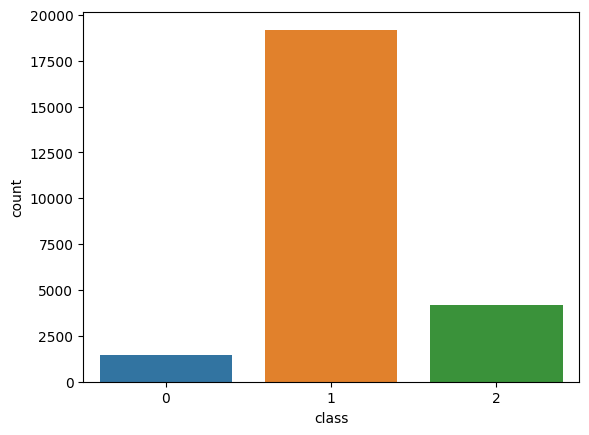

In [11]:
import seaborn as sns
sns.countplot(x='class',data=df)

In [12]:
df['tweet_cleaned']=df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [13]:
from datasets import Dataset
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [14]:
dataset = load_dataset('csv', data_files=data_path, split='train')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [15]:
train_test_valid = ds.train_test_split()
test_valid = train_test_valid['test'].train_test_split()
train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
 })

dataset = train_test_valid_dataset.remove_columns(['hate_speech','offensive_language','neither','Unnamed: 0','count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [16]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
text = "just checking tokenization"
output = tokenizer(text)
output

{'input_ids': [101, 1198, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [19]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'just', 'checking', 'token', '##ization', '[SEP]']

In [20]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] just checking tokenization [SEP]


In [21]:
print(f"Vocab_size is: {tokenizer.vocab_size}")

print(f"Model max length is: {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab_size is: 28996
Model max length is: 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [22]:
def tokenize_function(train_dataset):
  return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

In [23]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [26]:
train_set = train_dataset.remove_columns(['tweet',"tweet_cleaned"]).with_format('tensorflow')
tf_eval_dataset = eval_dataset.remove_columns(['tweet',"tweet_cleaned"]).with_format('tensorflow')
tf_test_dataset = test_dataset.remove_columns(['tweet',"tweet_cleaned"]).with_format('tensorflow')

In [28]:
train_features = {x: train_set[x] for x in tokenizer.model_input_names}
train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class']))
train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x:tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model = test_set_for_final_model.batch(8)

In [29]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy(),
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1722467829.303356     214 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2324/2324 [==============================] - 2476s 1s/step - loss: 0.3935 - sparse_categorical_accuracy: 0.8526 - val_loss: 0.4322 - val_sparse_categorical_accuracy: 0.8304
Epoch 2/3
2324/2324 [==============================] - 2357s 1s/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.4310 - val_sparse_categorical_accuracy: 0.8446
Epoch 3/3
2324/2324 [==============================] - 2354s 1s/step - loss: 0.4303 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.4065 - val_sparse_categorical_accuracy: 0.8928


In [31]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3)

Epoch 1/3
2324/2324 [==============================] - 2351s 1s/step - loss: 0.4231 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.6209 - val_sparse_categorical_accuracy: 0.7646
Epoch 2/3
2324/2324 [==============================] - 2352s 1s/step - loss: 0.6647 - sparse_categorical_accuracy: 0.7780 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.7648
Epoch 3/3
2324/2324 [==============================] - 2351s 1s/step - loss: 0.6618 - sparse_categorical_accuracy: 0.7780 - val_loss: 0.6799 - val_sparse_categorical_accuracy: 0.7648


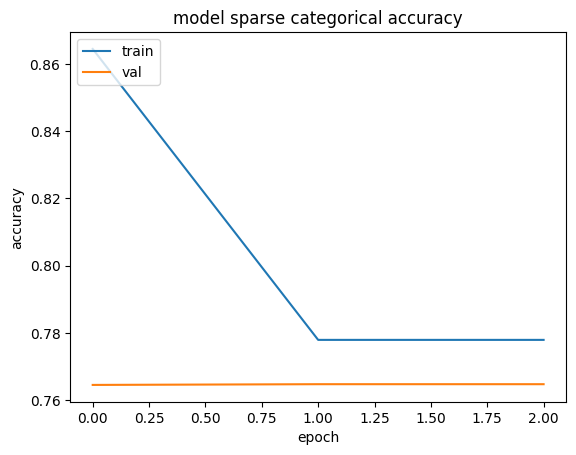

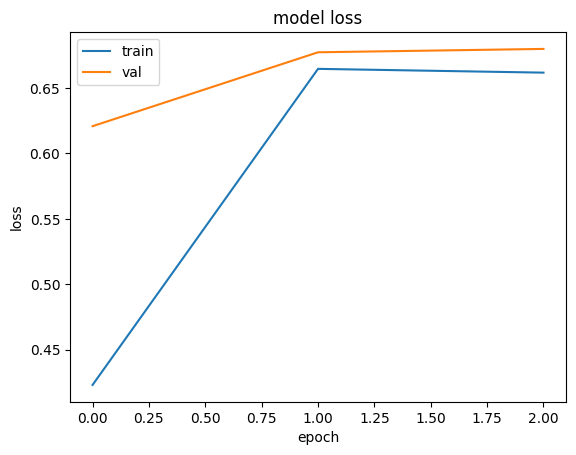

In [32]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:', test_acc)

194/194 - 64s - loss: 0.7032 - sparse_categorical_accuracy: 0.7592 - 64s/epoch - 332ms/step

Test accuracy: 0.7591995000839233


In [37]:
predict_score_and_class_dict = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'}

preds = model(tokenizer(["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"],
                        return_tensors="tf",padding=True,truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])


tf.Tensor(
[[-1.1483554   1.5570588  -0.09600195]
 [-1.1483558   1.5570585  -0.09600228]
 [-1.1483551   1.5570589  -0.09600175]], shape=(3, 3), dtype=float32)
Offensive Language
Offensive Language
Offensive Language
